In [8]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from hyperopt.pyll import scope
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np, xgboost as xgb
from xgboost import  XGBRegressor
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [5]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) MinMaxScaler cho X & y (fit trên TRAIN) ==================
xs = MinMaxScaler()
ys = MinMaxScaler()

X_train_prepared = xs.fit_transform(X_train)
X_test_prepared  = xs.transform(X_test)

y_train_prepared = ys.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_prepared  = ys.transform(y_test.values.reshape(-1, 1)).ravel()

# ================== 4) RandomizedSearchCV (CatBoost) ==================
param_distributions = {
    "n_estimators": [100, 200, 400],
    "learning_rate": [0.01, 0.03, 0.1, 0.2],
    "max_depth": [4, 6, 8, 10],     # <-- 'depth' (không phải 'max_depth')
}

model = XGBRegressor(
   
)

ran_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,                                  # bắt buộc với RandomizedSearchCV
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=SEED
)

ran_search.fit(X_train_prepared, y_train_prepared)

best_model   = ran_search.best_estimator_
best_params  = ran_search.best_params_
best_cv_rmse = np.sqrt(-ran_search.best_score_)   # RMSE trên THANG ĐÃ SCALE (y đã scale)

print("Best params:", best_params)
print(f"Best CV RMSE (scaled y): {best_cv_rmse:.6f}")

Best params: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.2}
Best CV RMSE (scaled y): 0.005673


In [17]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) CROSS-VALIDATION (CV metrics on scaled data) ==================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

mse_scores, mae_scores, rmse_scores, r2_scores = [], [], [], []

# Lưu toàn bộ giá trị thật và dự đoán từ các folds để scatter
all_true, all_pred = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), start=1):
    # --- split fold ---
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # --- scale INSIDE fold (fit trên train fold) ---
    xs, ys = MinMaxScaler(), MinMaxScaler()

    X_tr_s = xs.fit_transform(X_tr)                      # fit trên X_tr, transform X_tr
    X_te_s = xs.transform(X_te)                          # transform X_te

    y_tr_s = ys.fit_transform(y_tr.values.reshape(-1, 1)).ravel()  # fit trên y_tr
    y_te_s = ys.transform(y_te.values.reshape(-1, 1)).ravel()      # transform y_te

# --- CatBoost model (train & val đều dùng dữ liệu ĐÃ SCALE) ---
    model = XGBRegressor(
    max_depth= 8, learning_rate = 0.2, n_estimators= 200
)
    model.fit(
    X_tr_s, y_tr_s)

# --- predict & metrics (trên THANG ĐÃ SCALE) ---
    y_pred_s = model.predict(X_te_s)

    mse  = mean_squared_error(y_te_s, y_pred_s)
    mae  = mean_absolute_error(y_te_s, y_pred_s)
    rmse = float(np.sqrt(mse))
    r2   = r2_score(y_te_s, y_pred_s)

    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"[Fold {fold}] (SCALED) MSE={mse:.6f} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.6f}")

# ================== 4) CV AVERAGE ==================
print("\n=== CV AVERAGE (SCALED) ===")
print(f"Avg MSE : {np.mean(mse_scores):.6f}")
print(f"Avg MAE : {np.mean(mae_scores):.6f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.6f}")
print(f"Avg R²  : {np.mean(r2_scores):.6f}")

[Fold 1] (SCALED) MSE=0.000031 | RMSE=0.005526 | MAE=0.002413 | R²=0.804146
[Fold 2] (SCALED) MSE=0.000020 | RMSE=0.004525 | MAE=0.002412 | R²=0.847504
[Fold 3] (SCALED) MSE=0.000047 | RMSE=0.006891 | MAE=0.002481 | R²=0.709962
[Fold 4] (SCALED) MSE=0.000026 | RMSE=0.005081 | MAE=0.002394 | R²=0.823166
[Fold 5] (SCALED) MSE=0.000042 | RMSE=0.006518 | MAE=0.002467 | R²=0.726659
[Fold 6] (SCALED) MSE=0.000025 | RMSE=0.004970 | MAE=0.002422 | R²=0.830080
[Fold 7] (SCALED) MSE=0.000028 | RMSE=0.005288 | MAE=0.002450 | R²=0.819508
[Fold 8] (SCALED) MSE=0.000028 | RMSE=0.005274 | MAE=0.002442 | R²=0.816150
[Fold 9] (SCALED) MSE=0.000105 | RMSE=0.010271 | MAE=0.003735 | R²=0.760020
[Fold 10] (SCALED) MSE=0.000027 | RMSE=0.005163 | MAE=0.002414 | R²=0.831382

=== CV AVERAGE (SCALED) ===
Avg MSE : 0.000038
Avg MAE : 0.002563
Avg RMSE: 0.005951
Avg R²  : 0.796858


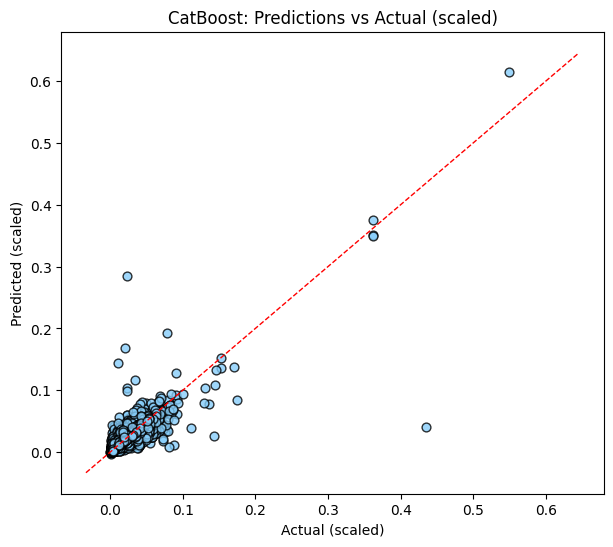

In [ ]:
from xgboost import  XGBRegressor
import numpy as np
import matplotlib.pyplot as plt


# ================== 4) TRAIN CATBOOST (SCALED) ==================
cb = XGBRegressor( max_depth= 8, learning_rate = 0.2, n_estimators= 200)
 

cb.fit(
    X_tr_s, y_tr_s
)

# ================== 5) PREDICT & SCATTER (SCALED) ==================
y_te_pred_s = cb.predict(X_te_s)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_te_s, y_te_pred_s, s=40, alpha=0.8,
           color="lightskyblue", edgecolors="k")

# Đường y = x theo giới hạn hiện tại của trục (không dùng 'lims')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([min(x0, y0), max(x1, y1)], [min(x0, y0), max(x1, y1)],
        "--", lw=1, color="red")

ax.set_title("XGBRegressor: Predictions vs Actual (scaled)")
ax.set_xlabel("Actual (scaled)")
ax.set_ylabel("Predicted (scaled)")
plt.show()


In [20]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = [
  'Original_len',
'Txn Fee','logIndex','actualGasCost',
    'Blockno','DateTime_ts', 'nonce'
]
target = 'Gas Used'


X = df[features].astype(float)
y = df[target].astype(float)

# Hold-out chỉ để cố định tập làm việc (không dùng test ở dưới)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# ================== 2) 20 EPOCHS × 10-FOLD ==================
epochs = 20
xg = np.zeros((epochs, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]

for ep in range(epochs):
    # shuffle train cho epoch này
    idx = np.random.permutation(len(X_train))
    X_ep = X_train.iloc[idx].reset_index(drop=True)
    y_ep = y_train.iloc[idx].reset_index(drop=True)

    KFold(n_splits=10, shuffle=True, random_state=SEED)

    rmse_scores, mse_scores, mae_scores, r2_scores = [], [], [], []

    for train_idx, val_idx in kf.split(X_ep):
        X_tr_raw, X_val_raw = X_ep.iloc[train_idx], X_ep.iloc[val_idx]
        y_tr_raw, y_val_raw = y_ep.iloc[train_idx], y_ep.iloc[val_idx]

        # scale TRONG fold (fit trên train → transform train/val)
        xs, ys = MinMaxScaler(), MinMaxScaler()
        X_tr_s = xs.fit_transform(X_tr_raw)
        X_val_s = xs.transform(X_val_raw)
        y_tr_s = ys.fit_transform(y_tr_raw.values.reshape(-1,1)).ravel()
        y_val_s = ys.transform(y_val_raw.values.reshape(-1,1)).ravel()

        # XGBoost (params mặc định, thêm random_state cho tái lập)
        model = XGBRegressor(n_estimators= 200, max_depth= 8, learning_rate= 0.2)
        model.fit(X_tr_s, y_tr_s)

        # metrics trên dữ liệu ĐÃ SCALE
        y_pred_s = model.predict(X_val_s)
        mse  = mean_squared_error(y_val_s, y_pred_s)
        rmse = float(np.sqrt(mse))
        mae  = mean_absolute_error(y_val_s, y_pred_s)
        r2   = r2_score(y_val_s, y_pred_s)

        rmse_scores.append(rmse); mse_scores.append(mse)
        mae_scores.append(mae);   r2_scores.append(r2)

    xg[ep, :] = [np.mean(rmse_scores), np.mean(mse_scores),
                 np.mean(mae_scores),  np.mean(r2_scores)]

# ================== 3) OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(xg, separator=', ', prefix='array(') + ")")

final_mean = xg.mean(axis=0)
final_std  = xg.std(axis=0, ddof=1)
print("\nMean over 20 runs (RMSE, MSE, MAE, R2):", final_mean)
print("Std  over 20 runs (RMSE, MSE, MAE, R2):", final_std)

array([[6.11789608e-03, 4.06582343e-05, 2.56373211e-03, 7.86757923e-01],
       [5.88863124e-03, 3.74558124e-05, 2.55512428e-03, 8.02482121e-01],
       [5.92400186e-03, 3.68940336e-05, 2.55256354e-03, 7.98115596e-01],
       [5.89557368e-03, 3.64830889e-05, 2.55727595e-03, 7.99412479e-01],
       [5.92631658e-03, 3.75172084e-05, 2.55764964e-03, 7.99805341e-01],
       [5.91111282e-03, 3.80614049e-05, 2.55817868e-03, 8.00373843e-01],
       [5.86726996e-03, 3.70165200e-05, 2.55616933e-03, 8.02231135e-01],
       [5.91635367e-03, 3.73707455e-05, 2.55911517e-03, 7.97660193e-01],
       [5.84656402e-03, 3.59101852e-05, 2.55682002e-03, 8.03515100e-01],
       [5.80888648e-03, 3.61341777e-05, 2.55217503e-03, 8.07345152e-01],
       [5.87366877e-03, 3.69938398e-05, 2.55543562e-03, 8.03038986e-01],
       [5.77542418e-03, 3.71568345e-05, 2.55466388e-03, 8.12234040e-01],
       [5.89270328e-03, 3.67195330e-05, 2.55587298e-03, 8.01010009e-01],
       [5.90221148e-03, 3.66601941e-05, 2.55543144e